<a href="https://colab.research.google.com/github/emorysmithis/pupil-cluster/blob/main/BCI_dilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import pandas as pd
import numpy as np
import torch

# Notes from class

could also be interesting to keep track of blinks because of correlations:
- dopamine
- working memory
-


In [146]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
raw_dataframe = pd.read_csv(
    '/content/drive/MyDrive/BCI/BCI_Final_Project/WM study/Eye data/Experiment 1/DWRSS6TET-1040-1.gazedata',
    sep='\t')


In [148]:
raw_dataframe

Subject  Session     ID      TETTime   RTTime  TimestampSec  \
0         1040        1      1   113065.384   112755           113   
1         1040        1      2   113073.665   112764           113   
2         1040        1      3   113081.996   112772           113   
3         1040        1      4   113090.330   112781           113   
4         1040        1      5   113098.666   112789           113   
...        ...      ...    ...          ...      ...           ...   
56403     1040        1  56404  1256276.587  1255967          1256   
56404     1040        1  56405  1256284.919  1255975          1256   
56405     1040        1  56406  1256293.251  1255983          1256   
56406     1040        1  56407  1256301.583  1255992          1256   
56407     1040        1  56408  1256309.915  1256000          1256   

       TimestampMicrosec XGazePosLeftEye  YGazePosLeftEye  XCameraPosLeftEye  \
0                  65384              -1        -1.000000          -1.000000   
1                  73665              -1        -1.000000          -1.000000   
2                  81996              -1        -1.000000          -1.000000   
3                  90330              -1        -1.000000          -1.000000   
4                  98666       0.6614372         0.441365           0.703515   
...                  ...             ...              ...                ...   
56403             276587              -1        -1.000000          -1.000000   
56404             284919              -1        -1.000000          -1.000000   
56405             293251              -1        -1.000000          -1.000000   
56406             301583              -1        -1.000000          -1.000000   
56407             309915              -1        -1.000000          -1.000000   

       ...  XGazePosRightEye  YGazePosRightEye  XCameraPosRightEye  \
0      ...         -1.000000         -1.000000           -1.000000   
1      ...         -1.000000         -1.000000           -1.000000   
2      ...         -1.000000         -1.000000           -1.000000   
3      ...         -1.000000         -1.000000           -1.000000   
4      ...          0.671188          0.610638            0.490636   
...    ...               ...               ...                 ...   
56403  ...         -1.000000         -1.000000           -1.000000   
56404  ...         -1.000000         -1.000000           -1.000000   
56405  ...         -1.000000         -1.000000           -1.000000   
56406  ...         -1.000000         -1.000000           -1.000000   
56407  ...         -1.000000         -1.000000           -1.000000   

       YCameraPosRightEye  DiameterPupilRightEye  DistanceRightEye  \
0               -1.000000              -1.000000           -1.0000   
1               -1.000000              -1.000000           -1.0000   
2               -1.000000              -1.000000           -1.0000   
3               -1.000000              -1.000000           -1.0000   
4                0.643655               3.529789          720.4445   
...                   ...                    ...               ...   
56403           -1.000000              -1.000000           -1.0000   
56404           -1.000000              -1.000000           -1.0000   
56405           -1.000000              -1.000000           -1.0000   
56406           -1.000000              -1.000000           -1.0000   
56407           -1.000000              -1.000000           -1.0000   

       ValidityRightEye  TrialId  NumCorrect  CurrentObject  
0                     4        1           2            NaN  
1                     4        1           2            NaN  
2                     4        1           2            NaN  
3                     4        1           2  PreTrialBlank  
4                     0        1           2  PreTrialBlank  
...                 ...      ...         ...            ...  
56403                 4       80           4           Mask  
56404                 4    

In [149]:
import glob

all_trial_dataframes = []
for filename in glob.glob('/content/drive/MyDrive/BCI/BCI_Final_Project/WM study/Eye data/*/*.gazedata'):
  raw_dataframe = pd.read_csv(
    filename,
    sep='\t',
    low_memory=False)
  # split by trial id
  for trial_id in raw_dataframe['TrialId'].unique():
    trial_dataframe = raw_dataframe[raw_dataframe['TrialId'] == trial_id]


    # drop metadata
    trial_dataframe = trial_dataframe.drop(columns=[
      'ID', 'RTTime', 'TimestampSec', 'TimestampMicrosec'])

    # drop specific movements since they will probably not be generalizable
    trial_dataframe = trial_dataframe.drop(columns=[
        'XGazePosLeftEye', 'YGazePosLeftEye', 'XCameraPosLeftEye', 'YCameraPosLeftEye',
        'XGazePosRightEye', 'YGazePosRightEye', 'XCameraPosRightEye', 'YCameraPosRightEye',
        'DistanceLeftEye', 'DistanceRightEye'
    ])

    all_trial_dataframes.append(trial_dataframe)

In [150]:
all_trial_dataframes[7]

Subject  Session     TETTime  DiameterPupilLeftEye  ValidityLeftEye  \
4935     1085        1  307418.164              3.734595                0   
4936     1085        1  307426.481              3.779053                0   
4937     1085        1  307434.813              3.762602                0   
4938     1085        1  307443.143              3.763395                0   
4939     1085        1  307451.474              3.761446                0   
...       ...      ...         ...                   ...              ...   
5636     1085        1  313258.916             -1.000000                4   
5637     1085        1  313267.244             -1.000000                4   
5638     1085        1  313275.580             -1.000000                4   
5639     1085        1  313283.911             -1.000000                4   
5640     1085        1  313292.247             -1.000000                4   

      DiameterPupilRightEye  ValidityRightEye  TrialId  NumCorrect  \
4935               4.005254                 0        8           5   
4936               3.958885                 0        8           5   
4937               3.966918                 0        8           5   
4938               3.948570                 0        8           5   
4939               3.948934                 0        8           5   
...                     ...               ...      ...         ...   
5636              -1.000000                 4        8           5   
5637              -1.000000                 4        8           5   
5638              -1.000000                 4        8           5   
5639              -1.000000                 4        8           5   
5640              -1.000000                 4        8           5   

      CurrentObject  
4935            NaN  
4936            NaN  
4937            NaN  
4938            NaN  
4939  PreTrialBlank  
...             ...  
5636           Mask  
5637           Mask  
5638           Mask  
5639           Mask  
5640           Mask  

[706 rows x 10 columns]

In [151]:
print(f"Num trials before removing any: {len(all_trial_dataframes)}")
 # NOTE: fixed this. You cannot pop inside the loop because that messes with the indexing.

filtered_all_trial_dataframes = []
for index, trial in enumerate(all_trial_dataframes):
  # 1. remove empty trials
  if trial.empty:
    continue
  # 2. remove trials where left pupil diameter is 0 more than threshold
  zero_threshold = len(trial) / 2 # half the time, 50%
  if sum(a > 0 for a in trial['DiameterPupilLeftEye']) < zero_threshold:
    continue

  # 3. remove trials where right pupil diameter is 0 more than threshold
  if sum(a > 0 for a in trial['DiameterPupilRightEye']) < zero_threshold:
    continue

  # 4. remove trials where validity of right eye is not valid more than threshold
  valid_threshold = len(trial) / 2
  if sum(a == 0 for a in trial['ValidityRightEye']) < zero_threshold:
    continue

  # 5. remove trials where validity of left eye is not valid more than threshold
  if sum(a == 0 for a in trial['ValidityLeftEye']) < zero_threshold:
    continue

  trial['ElapsedTime'] = trial['TETTime'] - trial['TETTime'].iloc[0]
  filtered_all_trial_dataframes.append(trial)


print(f"Num trials remaining after removing empty and half-empty trials: {len(filtered_all_trial_dataframes)}")
all_trial_dataframes = filtered_all_trial_dataframes

Num trials before removing any: 9200
Num trials remaining after removing empty and half-empty trials: 8073


[5544, 1552, 4024, 6461, 7495, 4258, 873, 7005, 1381, 6956]


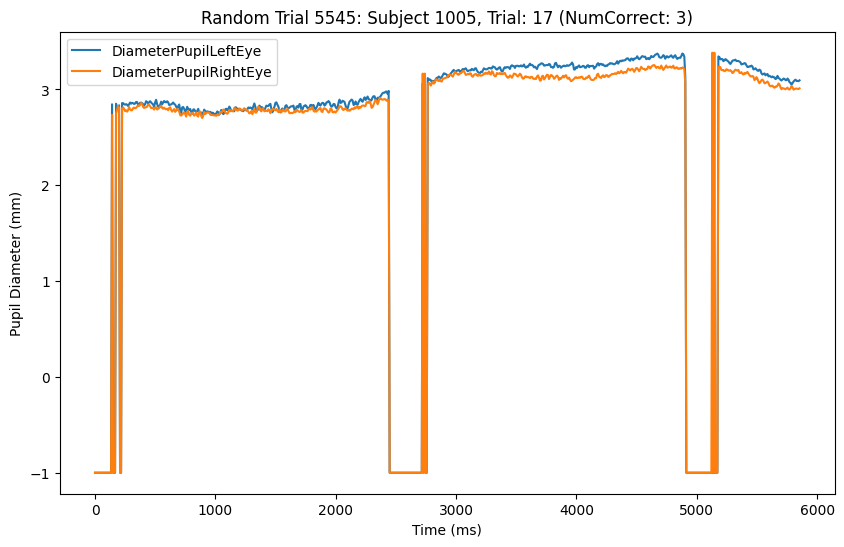

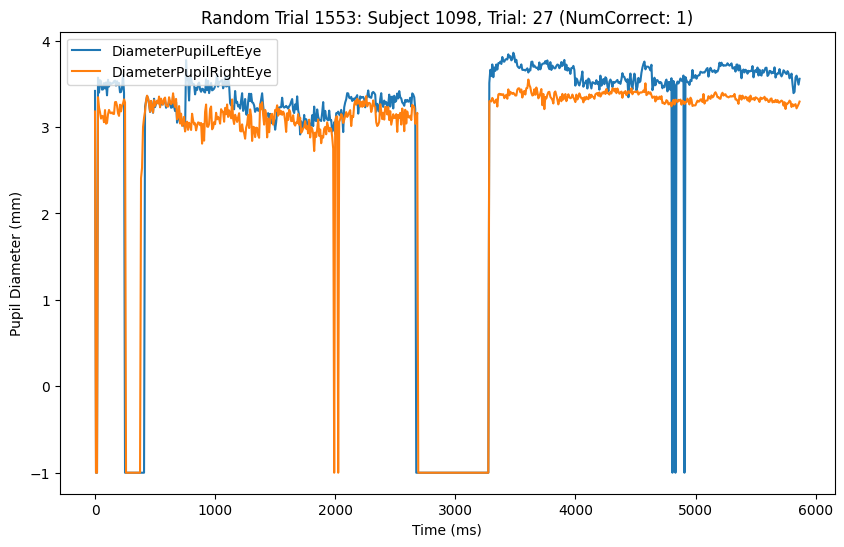

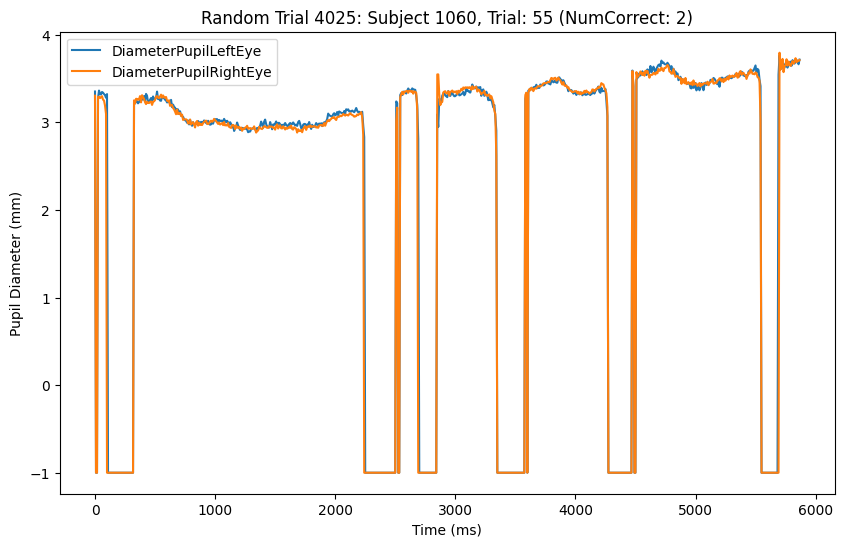

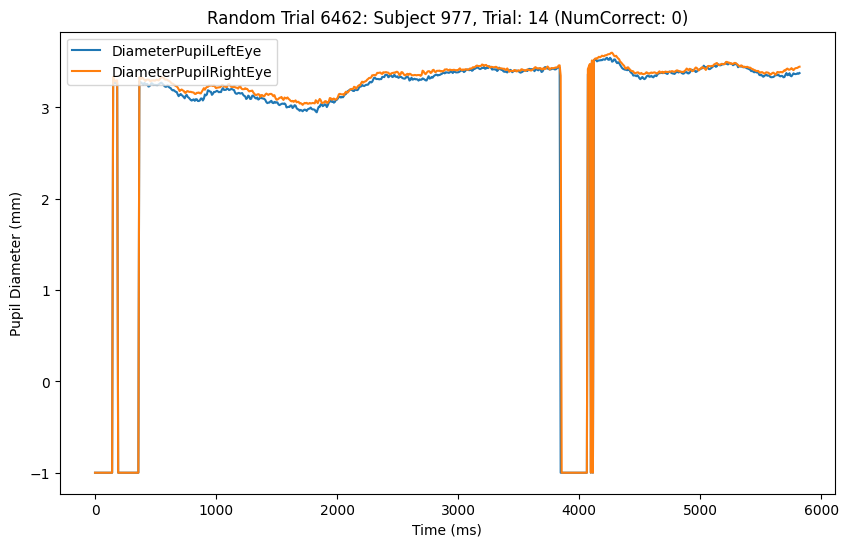

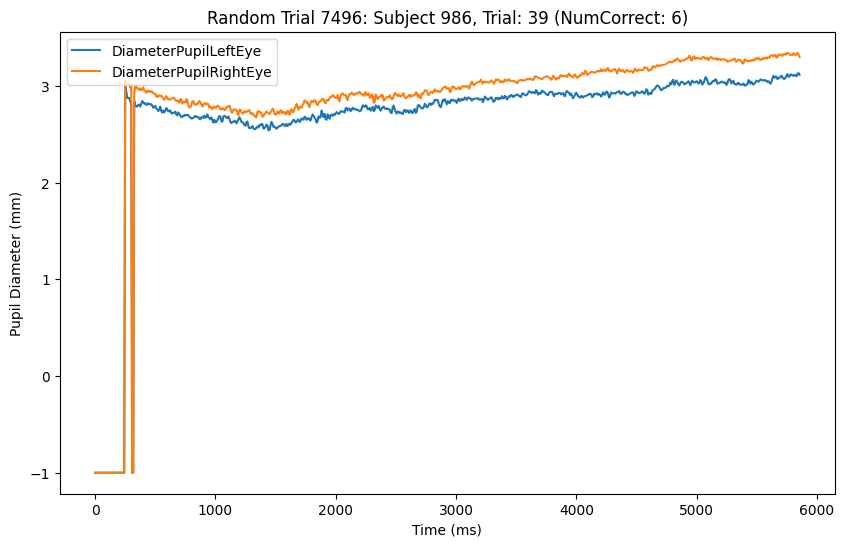

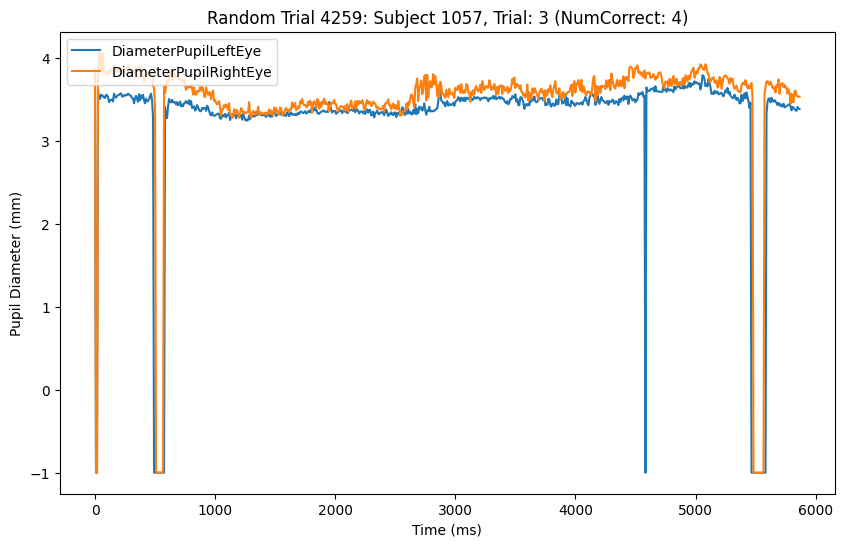

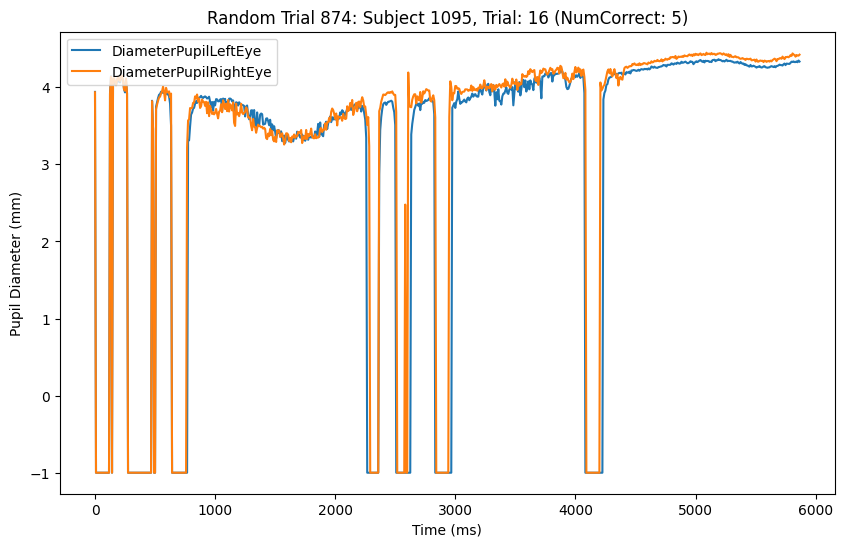

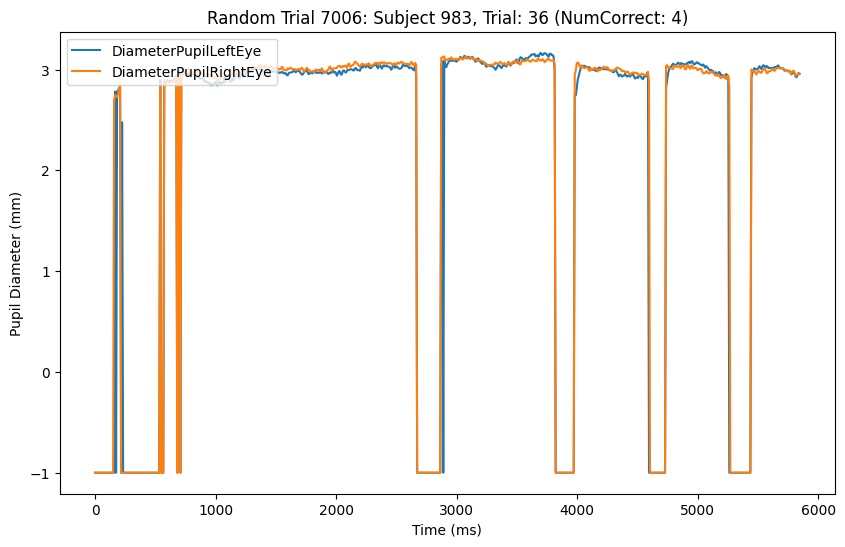

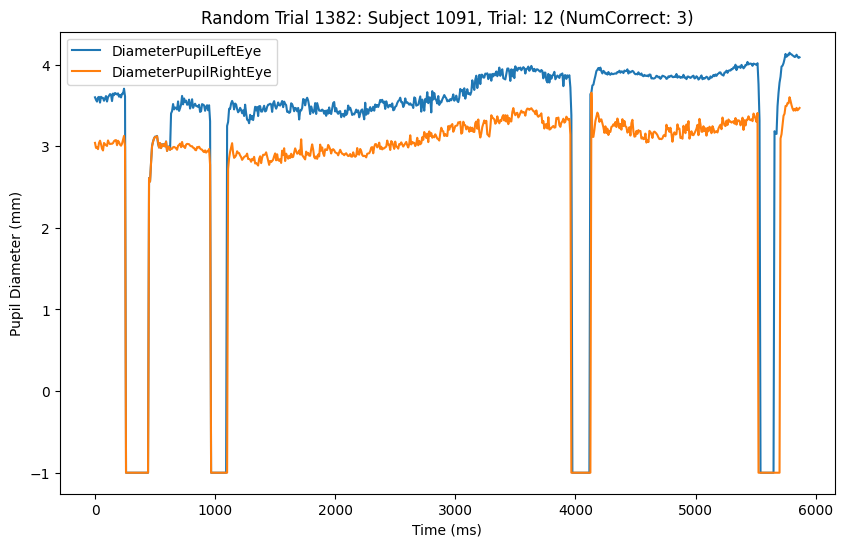

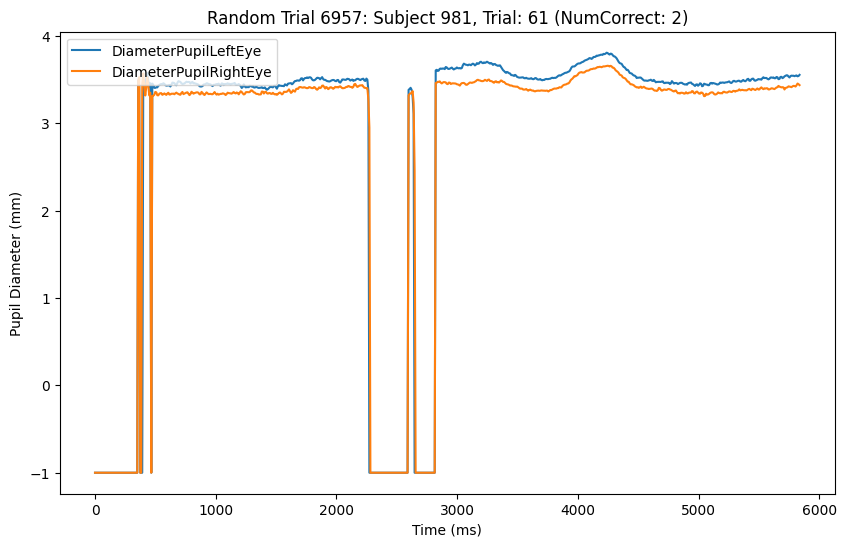

In [152]:
import random
import matplotlib.pyplot as plt

# Select three random trial dataframes
#random_trials = random.sample(filtered_all_trial_dataframes, 3)
numbers = random.sample(range(0, len(filtered_all_trial_dataframes)), 10)  # picks 3 unique numbers from 0 to x inclusive
print(numbers)



# Plot each trial
for i in numbers:
    trial_df = filtered_all_trial_dataframes[i]
    fig, ax1 = plt.subplots(figsize=(10, 6))

    for column in trial_df.columns:
        if column == 'DiameterPupilLeftEye' or column == 'DiameterPupilRightEye': # Exclude the label from plotting
          ax1.plot(trial_df['ElapsedTime'], trial_df[column], label=column)

    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Pupil Diameter (mm)')
    plt.title(f'Random Trial {i+1}: Subject {trial_df['Subject'].iloc[0]}, Trial: {trial_df["TrialId"].iloc[0]} (NumCorrect: {trial_df["NumCorrect"].iloc[0]})')
    ax1.legend(loc='upper left')
    plt.show()

In [153]:
# interpolate DiameterPupilLeftEye and DiameterPupilRightEye using MNE
MAX=6
MIN=1
num_linear_fallback = 0
for index, trial in enumerate(filtered_all_trial_dataframes):
  # also cutting bad data (e.g. eye partially closed)
  trial.loc[:, "DiameterPupilRightEye"] = trial["DiameterPupilRightEye"].apply(
    lambda x: np.nan if x < MIN or x > MAX else x)
  trial.loc[:, "DiameterPupilLeftEye"] = trial["DiameterPupilLeftEye"].apply(
    lambda x: np.nan if x < MIN or x > MAX else x)


  # TODO: need to do something about false values (blink making the percieved pupil diameter look tiny then interpolation making it blow up)
  # dumb way would be to also make values around blinks NanN too
  try:
    filtered_all_trial_dataframes[index].loc[:, 'DiameterPupilLeftEye'] = trial['DiameterPupilLeftEye'].interpolate(method='pchip')
    filtered_all_trial_dataframes[index].loc[:, 'DiameterPupilRightEye'] = trial['DiameterPupilRightEye'].interpolate(method='pchip')

    #filtered_all_trial_dataframes[index] = trial.interpolate(method='pchip')
  except:
    num_linear_fallback+=1
    filtered_all_trial_dataframes[index].loc[:, 'DiameterPupilLeftEye'] = trial['DiameterPupilLeftEye'].interpolate()
    filtered_all_trial_dataframes[index].loc[:, 'DiameterPupilRightEye'] = trial['DiameterPupilRightEye'].interpolate()

print(f"failed interpolation and fell back to linear {num_linear_fallback} times")

all_trial_dataframes[7]
num_nans_right = all_trial_dataframes[7]['DiameterPupilRightEye'].isna().sum()
print("NaNs in DiameterPupilRightEye:", num_nans_right)


failed interpolation and fell back to linear 0 times
NaNs in DiameterPupilRightEye: 0


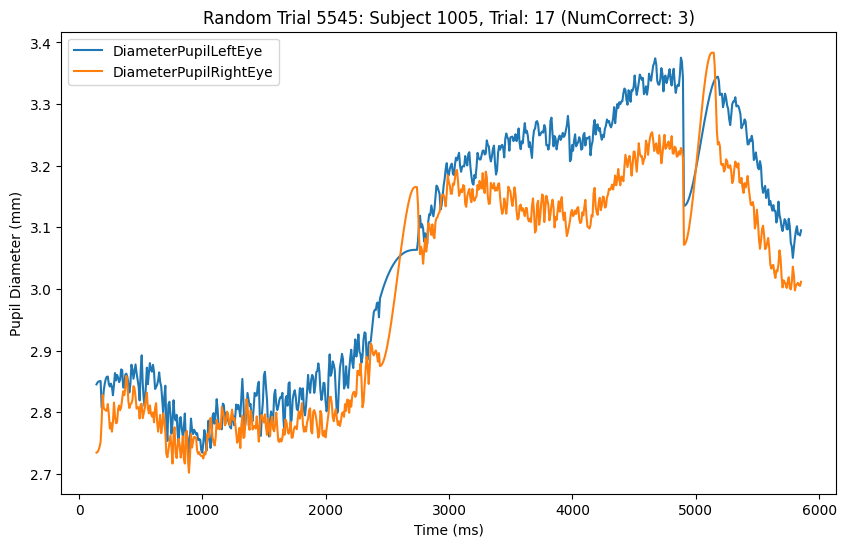

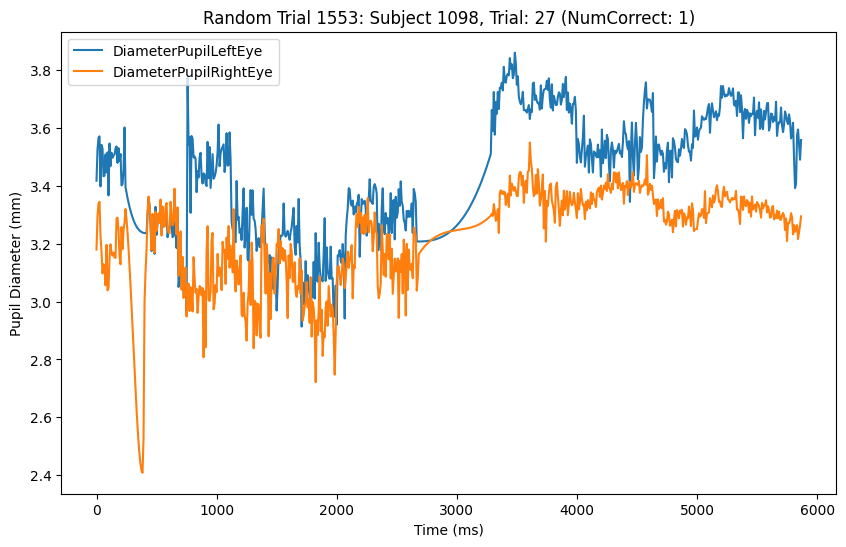

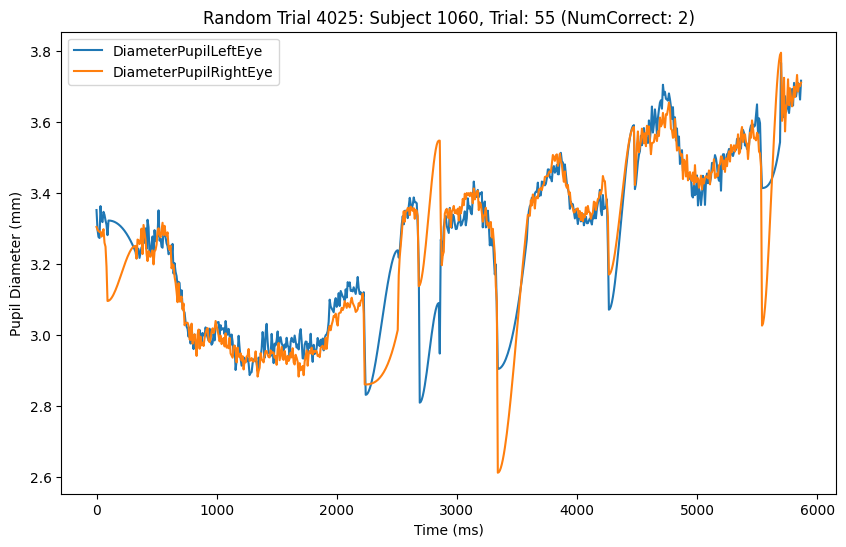

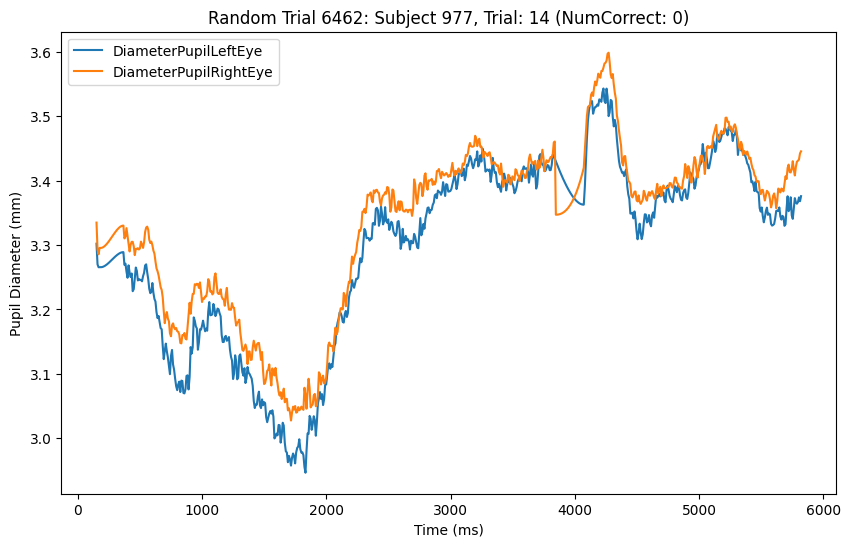

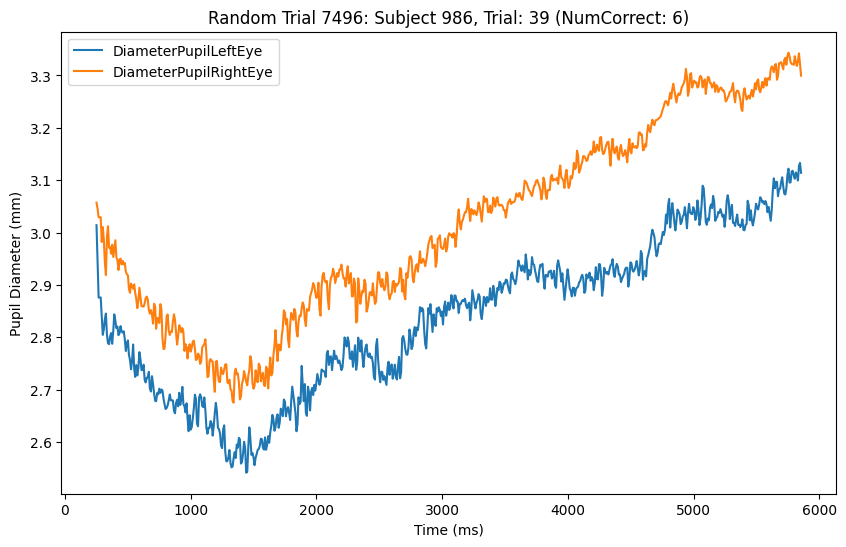

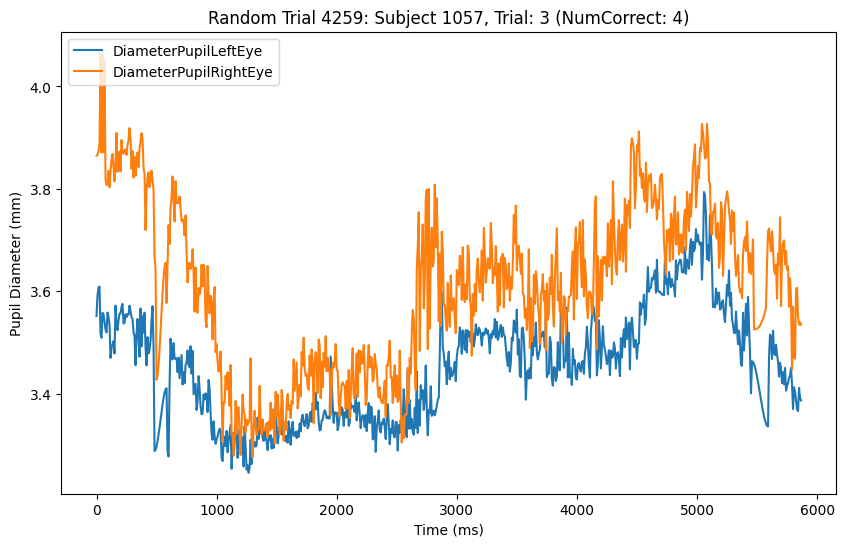

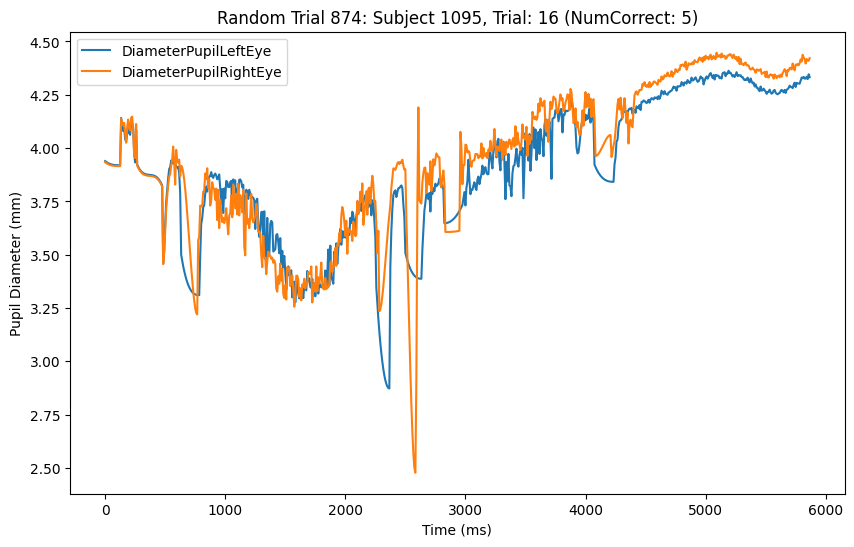

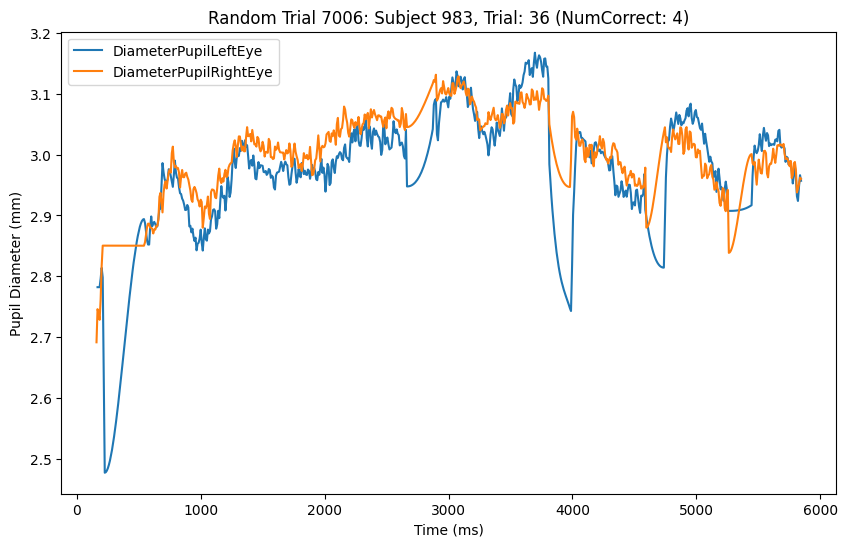

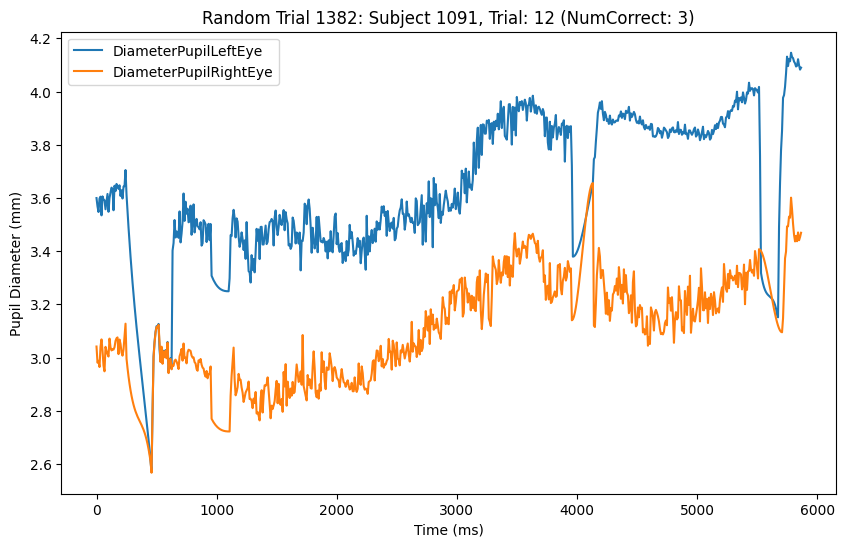

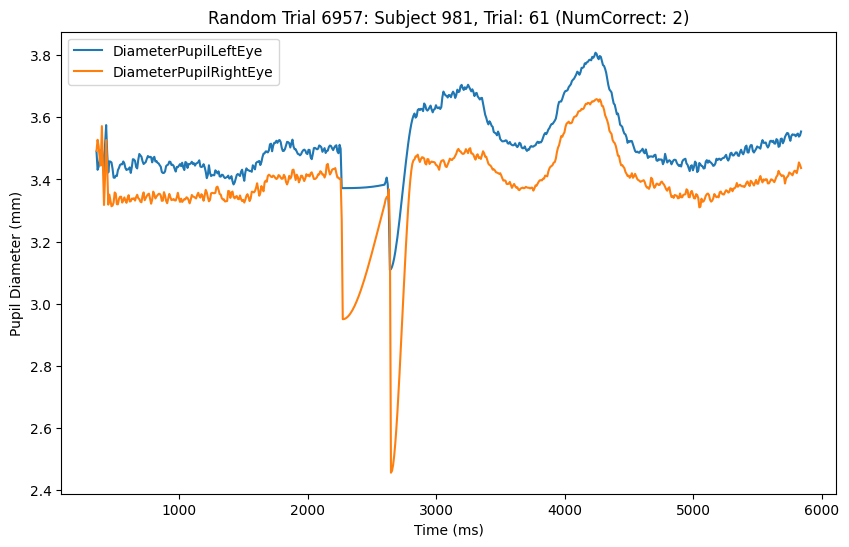

In [154]:
# Plot each trial
for i in numbers:
    trial_df = filtered_all_trial_dataframes[i]
    fig, ax1 = plt.subplots(figsize=(10, 6))

    for column in trial_df.columns:
        if column == 'DiameterPupilLeftEye' or column == 'DiameterPupilRightEye': # Exclude the label from plotting
          ax1.plot(trial_df['ElapsedTime'], trial_df[column], label=column)

    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Pupil Diameter (mm)')
    plt.title(f'Random Trial {i+1}: Subject {trial_df['Subject'].iloc[0]}, Trial: {trial_df["TrialId"].iloc[0]} (NumCorrect: {trial_df["NumCorrect"].iloc[0]})')
    ax1.legend(loc='upper left')
    plt.show()

In [155]:
filtered_all_trial_dataframes[0]

Subject  Session     TETTime  DiameterPupilLeftEye  ValidityLeftEye  \
0       1085        1  188447.346                   NaN                4   
1       1085        1  188455.626                   NaN                4   
2       1085        1  188463.958              3.680949                0   
3       1085        1  188472.289              3.693927                4   
4       1085        1  188480.622              3.704842                4   
..       ...      ...         ...                   ...              ...   
700     1085        1  194279.730              3.971760                0   
701     1085        1  194288.063              3.967884                0   
702     1085        1  194296.396              3.949835                0   
703     1085        1  194304.731              3.989667                0   
704     1085        1  194313.053              3.987294                0   

     DiameterPupilRightEye  ValidityRightEye  TrialId  NumCorrect  \
0                      NaN                 4        1           0   
1                      NaN                 4        1           0   
2                 3.931290                 0        1           0   
3                 3.930457                 4        1           0   
4                 3.927880                 4        1           0   
..                     ...               ...      ...         ...   
700               4.143275                 0        1           0   
701               4.138489                 0        1           0   
702               4.151855                 0        1           0   
703               4.127475                 0        1           0   
704               4.142232                 0        1           0   

     CurrentObject  ElapsedTime  
0              NaN        0.000  
1              NaN        8.280  
2    PreTrialBlank       16.612  
3    PreTrialBlank       24.943  
4    PreTrialBlank       33.276  
..             ...          ...  
700           Mask     5832.384  
701           Mask     5840.717  
702           Mask     5849.050  
703           Mask     5857.385  
704           Mask     5865.707  

[705 rows x 11 columns]

In [156]:
from IPython.display import display, HTML
mask_dataframes = []
for index, trial_df in enumerate(filtered_all_trial_dataframes):
  fixation_df = trial_df[trial_df["CurrentObject"] == "Fixation"]

  baseline_left_pupil = fixation_df[fixation_df["DiameterPupilLeftEye"] != -1]["DiameterPupilLeftEye"].mean() # get mean of pupil diameter, but don't include diameter == -1
  baseline_right_pupil = fixation_df[fixation_df["DiameterPupilRightEye"] != -1]["DiameterPupilRightEye"].mean() # get mean of pupil diameter, but don't include diameter == -1

  trial_df.loc[:, "DilationPupilRightEye"] = np.where(
    (trial_df["CurrentObject"] == "Mask") & (trial_df["DiameterPupilRightEye"] != -1),
    trial_df["DiameterPupilRightEye"] - baseline_right_pupil,
    np.nan)

  trial_df.loc[:, "DilationPupilLeftEye"] = np.where(
    (trial_df["CurrentObject"] == "Mask") & (trial_df["DiameterPupilLeftEye"] != -1),
    trial_df["DiameterPupilLeftEye"] - baseline_left_pupil,
    np.nan)

mask_dataframes = [df.loc[df["CurrentObject"] == "Mask"].copy() for df in filtered_all_trial_dataframes] # remove all parts of trial except "delay period" which is the period we care about
display(HTML(mask_dataframes[7].to_html()))

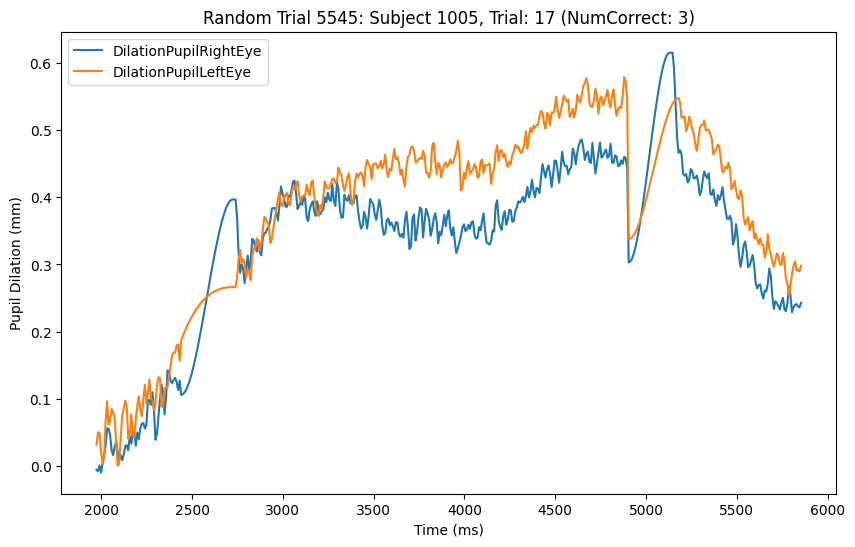

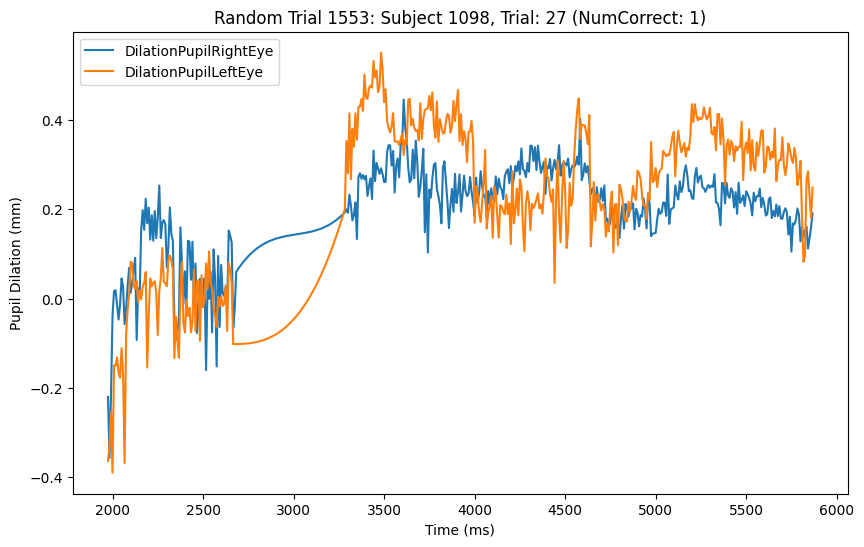

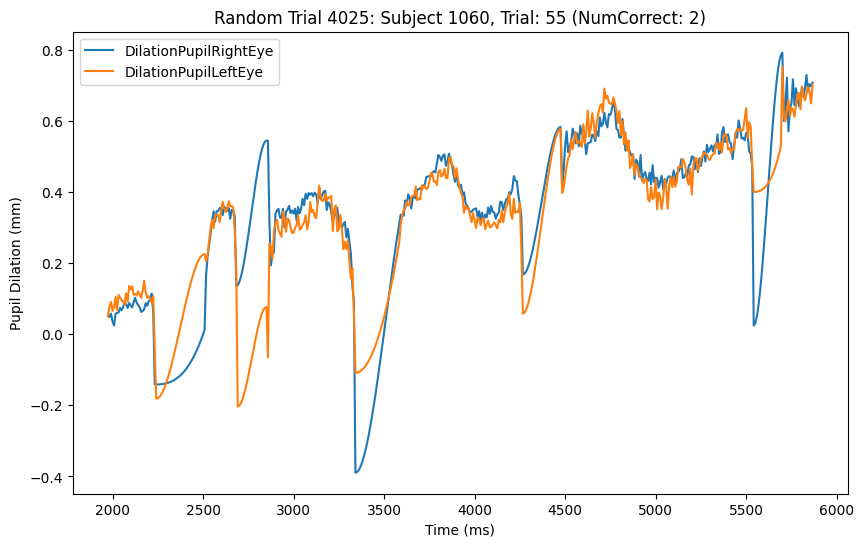

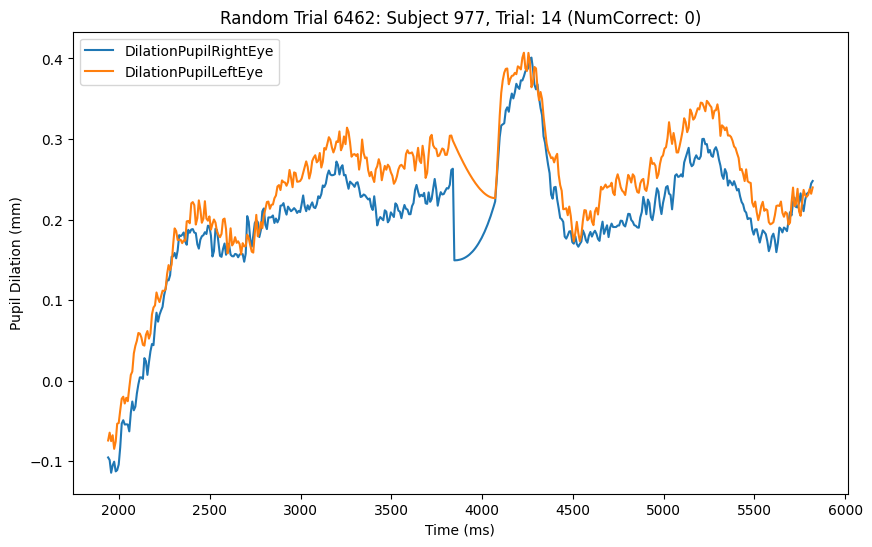

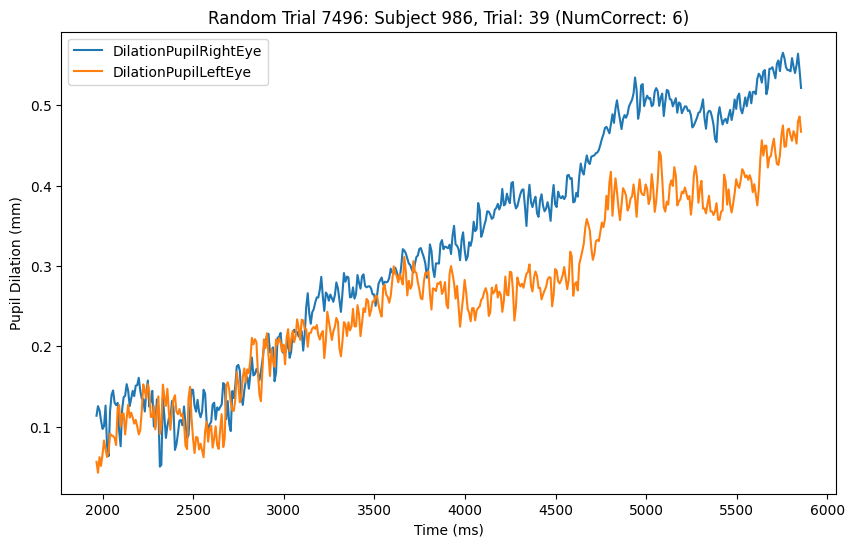

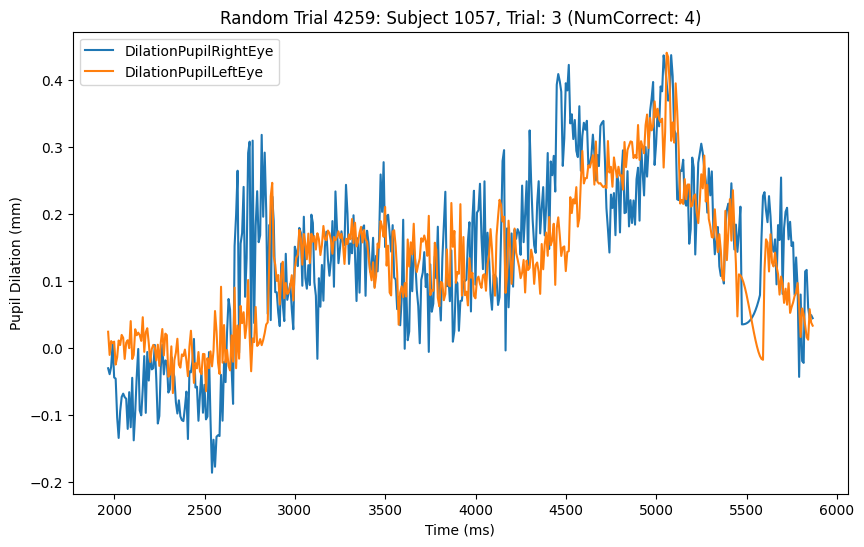

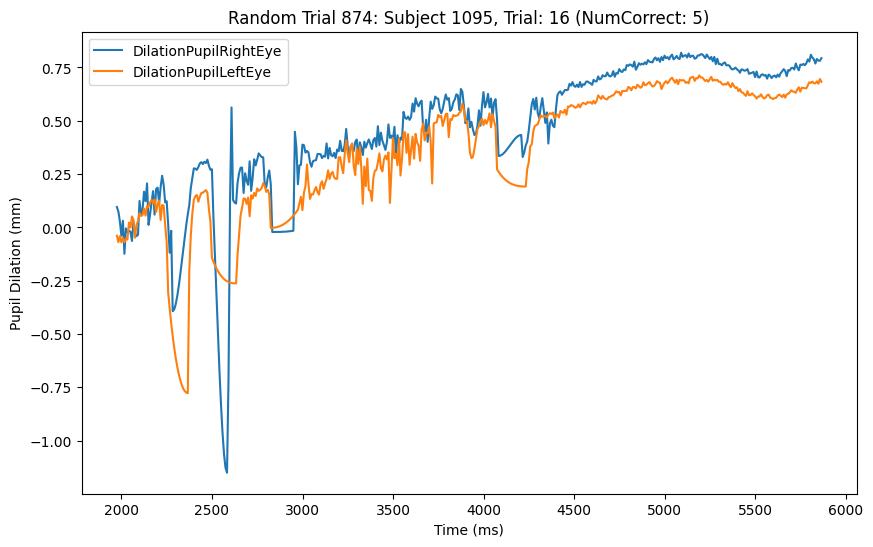

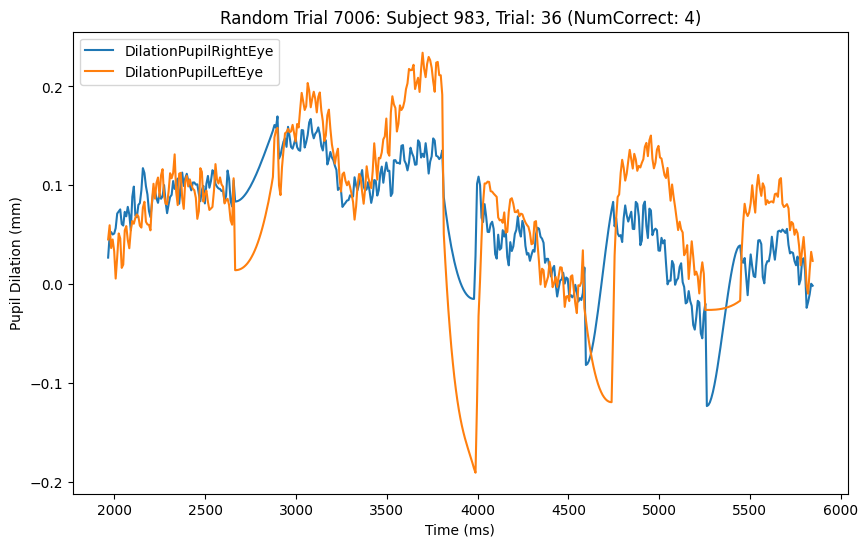

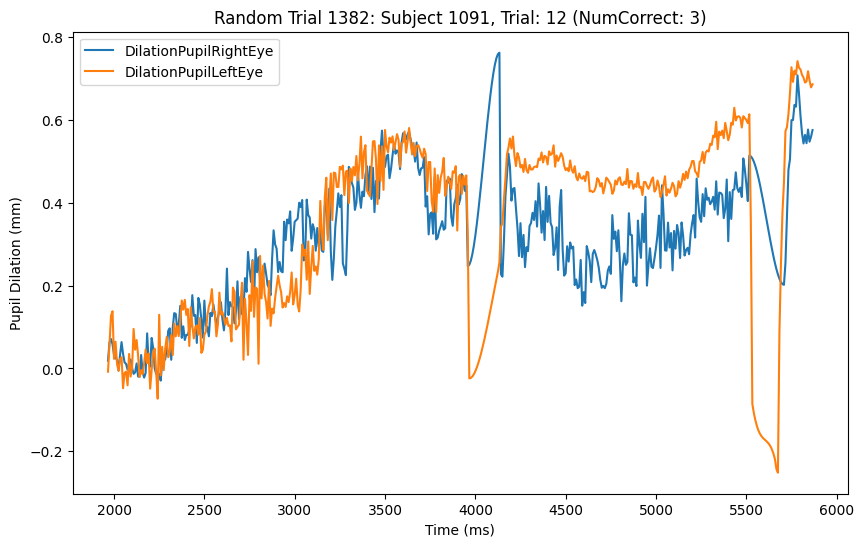

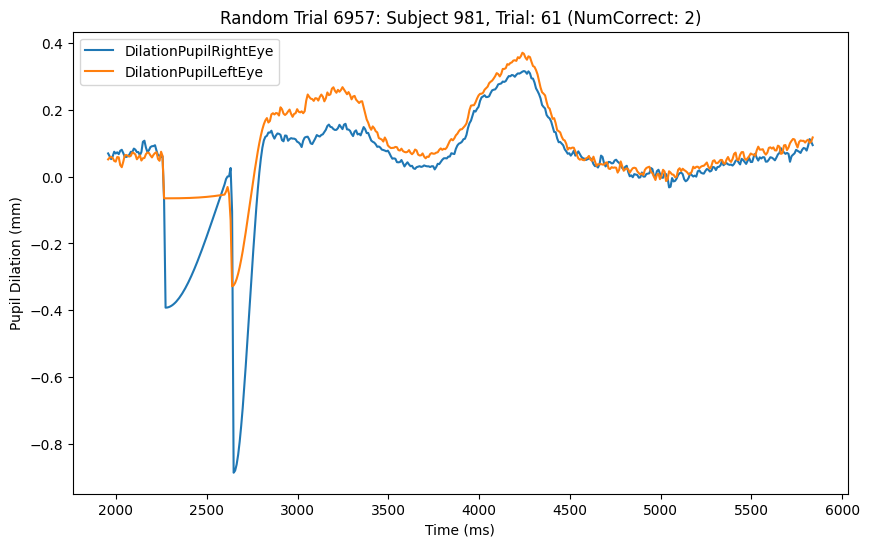

In [157]:
# Plot each trial
for i in numbers:
    trial_df = mask_dataframes[i]
    fig, ax1 = plt.subplots(figsize=(10, 6))

    for column in trial_df.columns:
        if column == 'DilationPupilLeftEye' or column == 'DilationPupilRightEye': # Exclude the label from plotting
          ax1.plot(trial_df['ElapsedTime'], trial_df[column], label=column)

    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Pupil Dilation (mm)')
    plt.title(f'Random Trial {i+1}: Subject {trial_df['Subject'].iloc[0]}, Trial: {trial_df["TrialId"].iloc[0]} (NumCorrect: {trial_df["NumCorrect"].iloc[0]})')
    ax1.legend(loc='upper left')
    plt.show()

In [158]:
# Low Pass Filter
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Filter
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# parameters
fs = 120  # sampling rate in Hz (change to your eye tracker rate)
cutoff = 5  # cutoff frequency in Hz

for i, trial_df in enumerate(mask_dataframes):
  mask_dataframes[i].loc[:, 'SmoothedDilationPupilLeftEye'] = lowpass_filter(
    mask_dataframes[i]['DilationPupilLeftEye'], cutoff, fs)
  mask_dataframes[i].loc[:, 'SmoothedDilationPupilRightEye'] = lowpass_filter(
    mask_dataframes[i]['DilationPupilRightEye'], cutoff, fs)




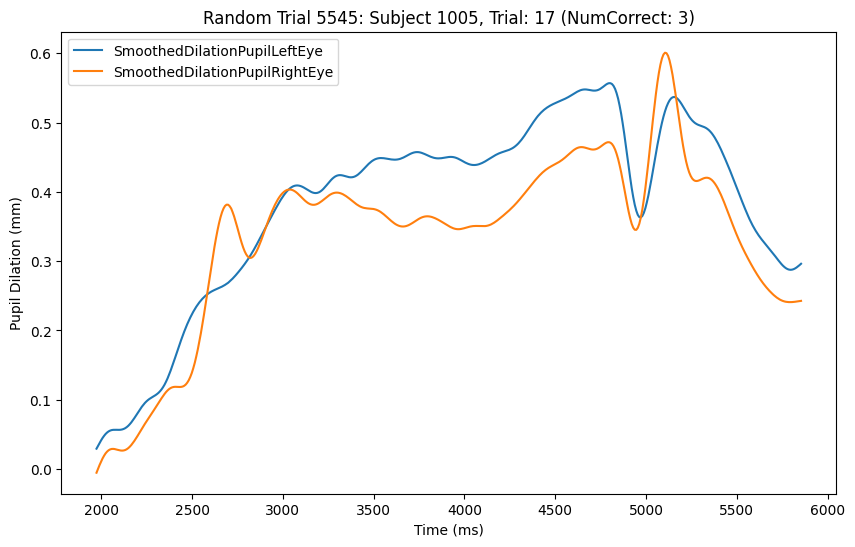

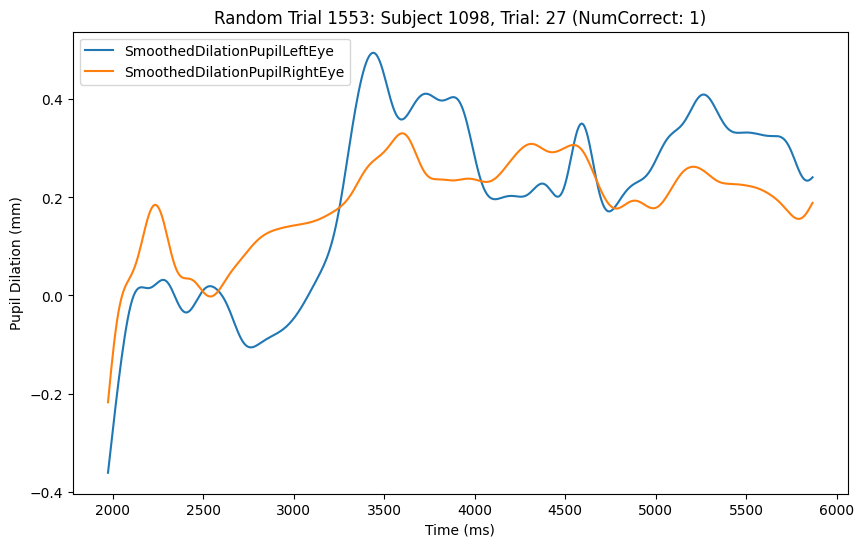

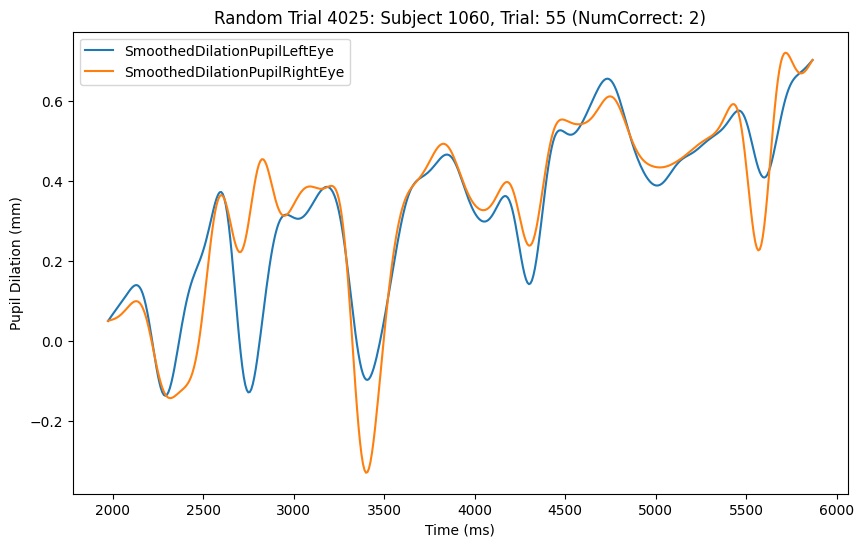

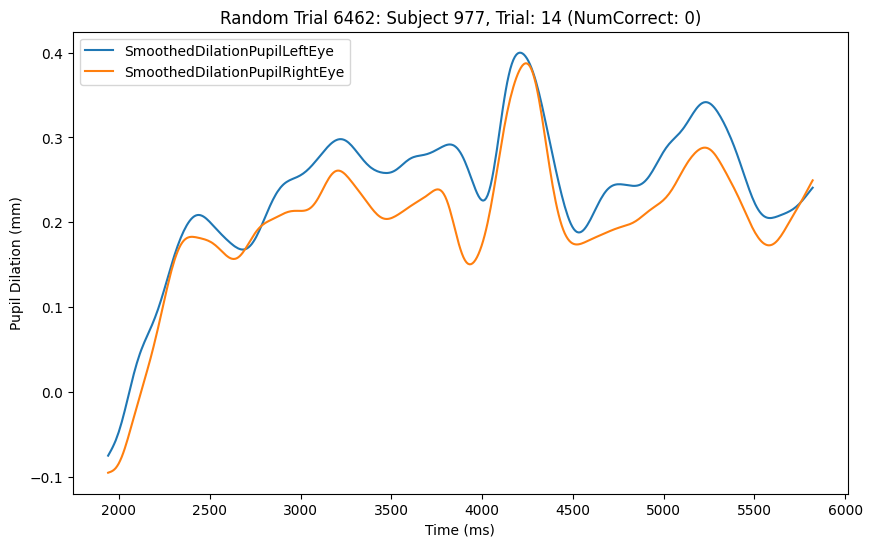

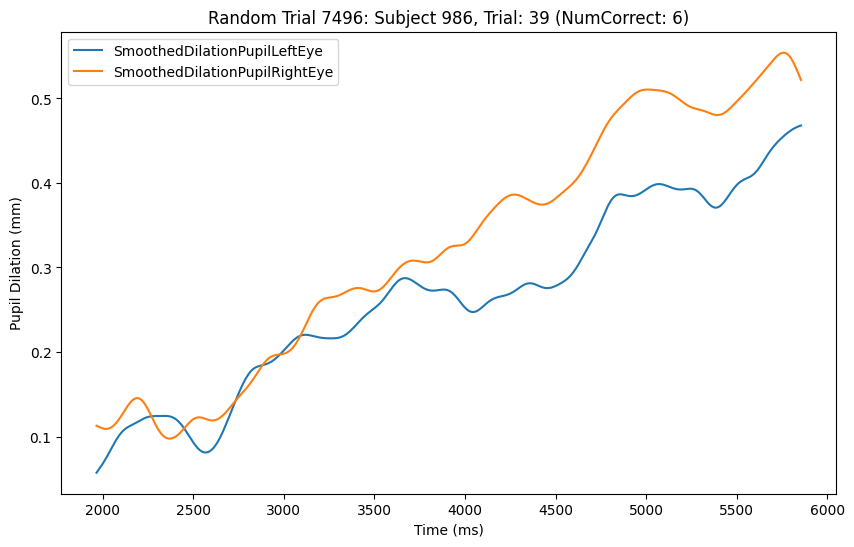

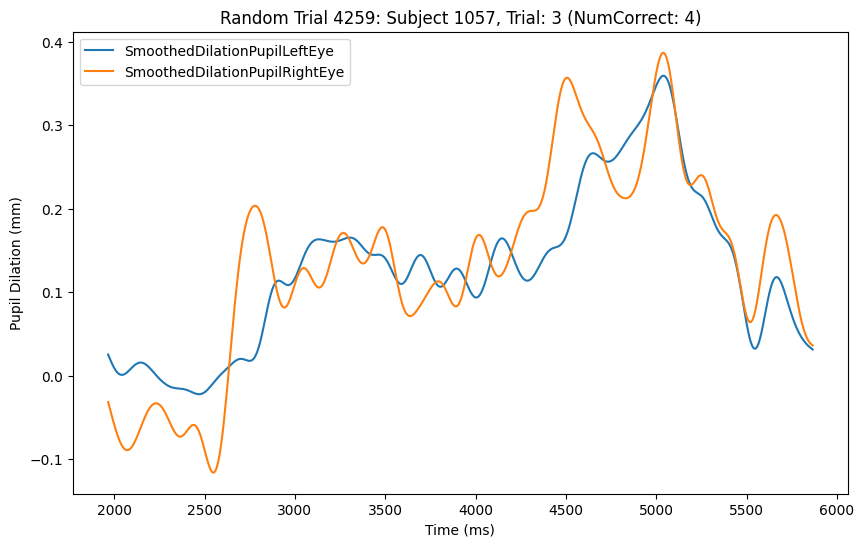

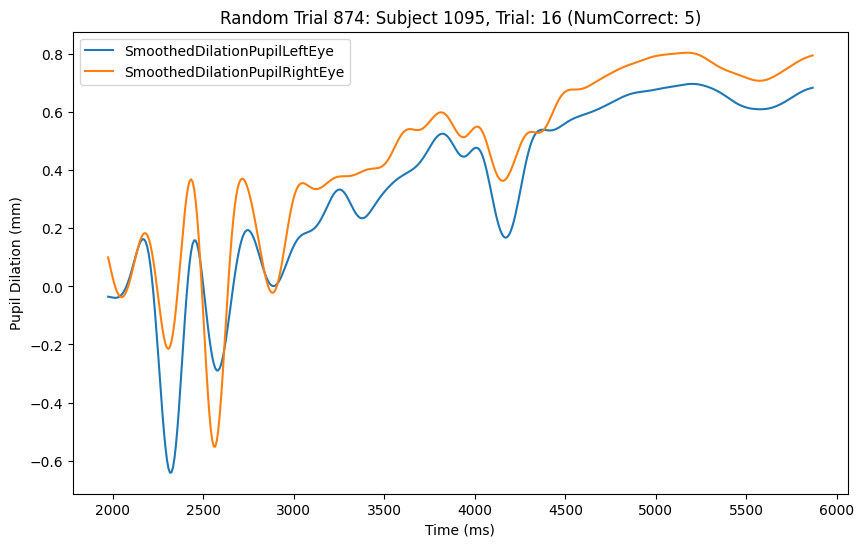

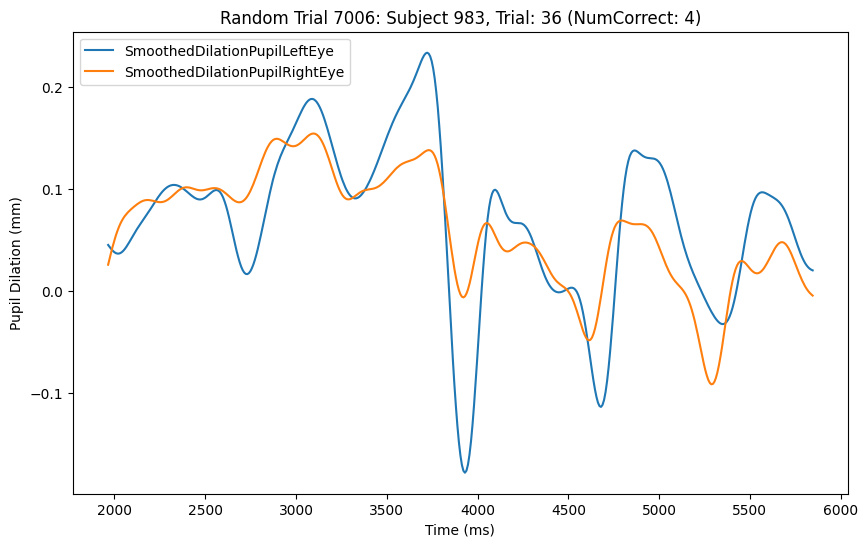

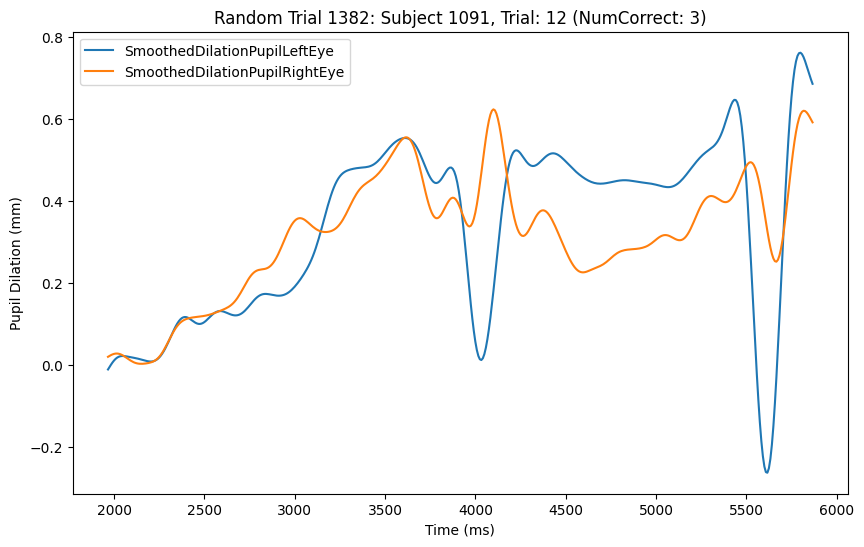

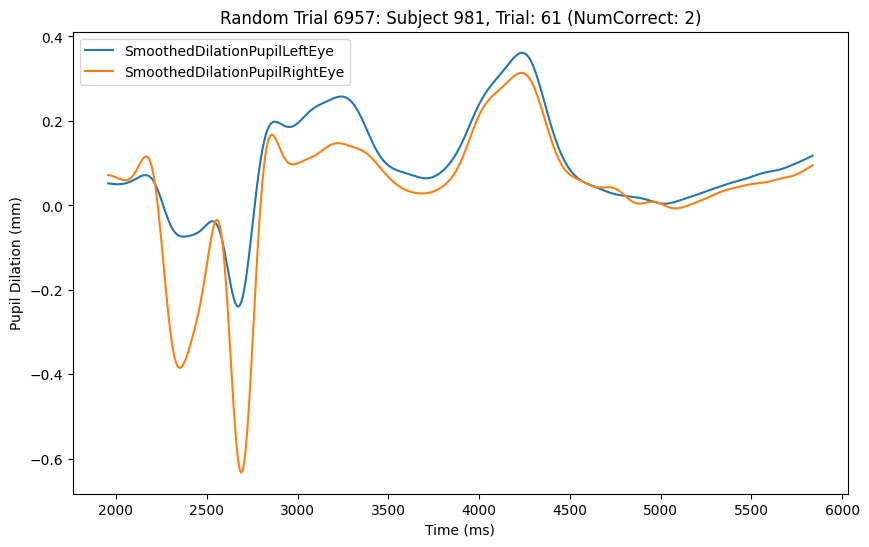

In [159]:
# Plot each trial
for i in numbers:
    trial_df = mask_dataframes[i]
    fig, ax1 = plt.subplots(figsize=(10, 6))

    for column in trial_df.columns:
        if column == 'SmoothedDilationPupilLeftEye' or column == 'SmoothedDilationPupilRightEye': # Exclude the label from plotting
          ax1.plot(trial_df['ElapsedTime'], trial_df[column], label=column)

    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Pupil Dilation (mm)')
    plt.title(f'Random Trial {i+1}: Subject {trial_df['Subject'].iloc[0]}, Trial: {trial_df["TrialId"].iloc[0]} (NumCorrect: {trial_df["NumCorrect"].iloc[0]})')
    ax1.legend(loc='upper left')
    plt.show()